In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
#Recomendador basado en una red neuronal

# Cargar los datos
ratings_data = pd.read_csv('tourism_rating.csv')

min_rating = min(ratings_data['Place_Ratings'])

max_rating = max(ratings_data['Place_Ratings'])

#x = ratings_data[['User_Id', 'Place_Id']].values
#y = ratings_data['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values


# Separar los datos en entrenamiento y prueba
train_data, test_data = train_test_split(ratings_data, test_size=0.2)


In [ ]:
# Crear los IDs para usuarios y películas
user_ids = ratings_data["User_Id"].unique().tolist()
place_ids = ratings_data["Place_Id"].unique().tolist()

# Crear los diccionarios de mapeo
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
place2place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded2place = {i: x for i, x in enumerate(place_ids)}

# Mapear los datos en los IDs
train_data["user"] = train_data["User_Id"].map(user2user_encoded)
train_data["place"] = train_data["Place_Id"].map(place2place_encoded)

test_data["user"] = test_data["User_Id"].map(user2user_encoded)
test_data["place"] = test_data["Place_Id"].map(place2place_encoded)

# Extraer las entradas y salidas
X_train = train_data[["user", "place"]].values
y_train = train_data["Place_Ratings"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

X_test = test_data[["user", "place"]].values
y_test = test_data["Place_Ratings"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Definir la arquitectura de la red neuronal
class RecommenderNet(tf.keras.Model):

    def __init__(self, num_users, num_places, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_places = num_places
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer=keras.initializers.RandomNormal(),
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.place_embedding = layers.Embedding(
            num_places,
            embedding_size,
            embeddings_initializer=keras.initializers.RandomNormal(),
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.dense1 = layers.Dense(64, activation="relu")
        self.dense2 = layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        concatenated = tf.concat([user_vector, place_vector], axis=-1)
        dense1_output = self.dense1(concatenated)
        output = self.dense2(dense1_output)
        return output

# Crear la instancia del modelo
model = RecommenderNet(
    num_users=len(user2user_encoded),
    num_places=len(place2place_encoded),
    embedding_size=32
)

# Compilar el modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=["mse"],
)

# Entrenar el modelo
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=100,
    verbose=1,
    validation_data=(X_test, y_test),
)

results = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
print("Test loss:", results[0])
print("Test accuracy:", results[1])
y_pred = model.predict(X_test)



# Obtener las 10 películas con mayor valoración para el usuario 1
user_id = 1
user_ratings = y_pred[:, user_id - 1]
top_10_indices = (-user_ratings).argsort()[:10]
#top_10_movies = movies_df.iloc[top_10_indices]['title']
#print(top_10_movies)

Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 0.1187 - mse: 0.1187 - val_loss: 0.1202 - val_mse: 0.1201
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1151 - mse: 0.1151 - val_loss: 0.1208 - val_mse: 0.1207
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1107 - mse: 0.1107 - val_loss: 0.1232 - val_mse: 0.1231
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1071 - mse: 0.1071 - val_loss: 0.1249 - val_mse: 0.1248
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1038 - mse: 0.1037 - val_loss: 0.1258 - val_mse: 0.1257
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0998 - mse: 0.0997 - val_loss: 0.1265 - val_mse: 0.1264
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0944 - mse: 0.0943 - val_loss: 0.1304 - val_mse: 0.1302
Epoch 8/100
125/125 [==============================] - 0s 3ms/step - 

In [ ]:
user_id = 10
place_id = 344
user_encoded = user2user_encoded.get(user_id)
place_encoded = place2place_encoded.get(place_id)
prediction = model.predict(np.array([[user_encoded, place_encoded]]))
print(prediction[0][0]* (max_rating - min_rating) + min_rating)

1/1 [==============================] - 0s 37ms/step
2.993072748184204


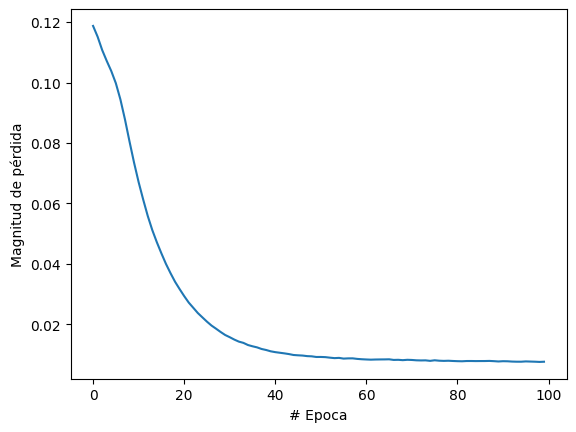

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(history.history['loss'])

In [ ]:
def print_metrics_by_epoch(history, loss_metric, mse_metric, every=10):
    print("Epoch\tLoss\tMSE")
    for i, (loss, mse) in enumerate(zip(history.history[loss_metric], history.history[mse_metric])):
        if (i + 1) % every == 0 or i == 0:
            print(f"{i+1}\t{loss:.4f}\t{mse:.4f}")

print_metrics_by_epoch(history, 'loss', 'mse')

Epoch	Loss	MSE
1	0.1187	0.1187
10	0.0735	0.0733
20	0.0317	0.0313
30	0.0165	0.0161
40	0.0111	0.0106
50	0.0092	0.0087
60	0.0084	0.0079
70	0.0083	0.0077
80	0.0079	0.0073
90	0.0077	0.0071
100	0.0076	0.0070
